***
## Anomaly/Outlier Detection Model with AutoEncoder for **Predictive Maintenance**
 
* initial save:             04/2020
* modified for training:    07/2021
* updated for 7/10/2021 event (ML/AI community)

Dataset can be taken from: https://www.kaggle.com/vinayak123tyagi/bearing-dataset
(set n.1 used)

Inspired by: 
* https://blog.keras.io/building-autoencoders-in-keras.html
* https://keras.io/examples/timeseries/timeseries_anomaly_detection/

***

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from numpy.random import seed

# I'm using seaborn for plots
sns.set(color_codes=True)
%matplotlib inline

# code for Tensorflow 2.3 !!!
print(tf.__version__)
assert(tf.__version__ >= '2.3')
print('Check TF version Ok')

2.3.2
Check TF version Ok


In [2]:
# to make it more deterministic
SEED = 1234

# numpy
seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# this is the code to setup the Strategy to work on multiple GPUs
# we will set anyway as if we have multiple GPU

# change this to TPU if you want to work on TPU and add the code..
DEVICE = "GPU"

if DEVICE == "GPU":
    n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", n_gpu)
    
    if n_gpu > 1:
        print("Using strategy for multiple GPU")
        strategy = tf.distribute.MirroredStrategy()
    else:
        print('Standard strategy for GPU...')
        strategy = tf.distribute.get_strategy()

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

print(f'REPLICAS: {REPLICAS}')

Num GPUs Available:  1
Standard strategy for GPU...
REPLICAS: 1


In [4]:
# globals
FIGSIZE = (12,8)

# utilities functions
def plot_loss(history, start_from=0):
    plt.figure(figsize = FIGSIZE)
    hist_loss = history.history['loss']
    hist_val_loss = history.history['val_loss']
    vet_epochs = range(start_from, len(hist_val_loss))
    
    plt.plot(vet_epochs, hist_loss[start_from:],'b', label='Training loss')
    plt.plot(vet_epochs, hist_val_loss[start_from:],'r', label='Validation loss')

    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (mse)')
    plt.ylim([0,.01])

    plt.show()

def extract_date(x):
    return str(pd.to_datetime(x).date())

def compute_and_plot_anomalies(score, title):
    # extract day
    score['Day'] = score.index
    score['Day'] = score['Day'].apply(extract_date)

    vet_x = score.groupby(['Day']).sum().index
    vet_y = score.groupby(['Day']).sum()['Anomaly']

    plt.figure(figsize=FIGSIZE)
    plt.title(title)
    sns.barplot(x=vet_x, y=vet_y)

    plt.xticks(rotation=90)
    plt.grid(True)
    
    return vet_x, vet_y

### Load from the single datafile (prepared by Anomaly1DataPreparation NB)

In [5]:
FILE_NAME = "./data_out/BearingsNasaTest1.csv"

result_data = pd.read_csv(FILE_NAME, index_col = 0)

# take care of the data format !
# the first column is used as index of the DF

result_data.index = pd.to_datetime(result_data.index, format='%Y-%m-%d %H:%M:%S')
result_data = result_data.sort_index()

In [6]:
result_data.head()

,Br11,Br12,Br21,Br22,Br31,Br32,Br41,Br42
2003-10-22 12:06:24,0.1041,0.1003,0.1071,0.1020,0.1061,0.1082,0.0948,0.0995
2003-10-22 12:09:13,0.1037,0.0999,0.1082,0.1029,0.1067,0.1085,0.0951,0.0936
2003-10-22 12:14:13,0.1050,0.1015,0.1085,0.1040,0.1087,0.1099,0.0962,0.0983
2003-10-22 12:19:13,0.1049,0.1016,0.1082,0.1034,0.1081,0.1100,0.0968,0.0986
2003-10-22 12:24:13,0.1048,0.1022,0.1079,0.1026,0.1085,0.1093,0.0964,0.0985


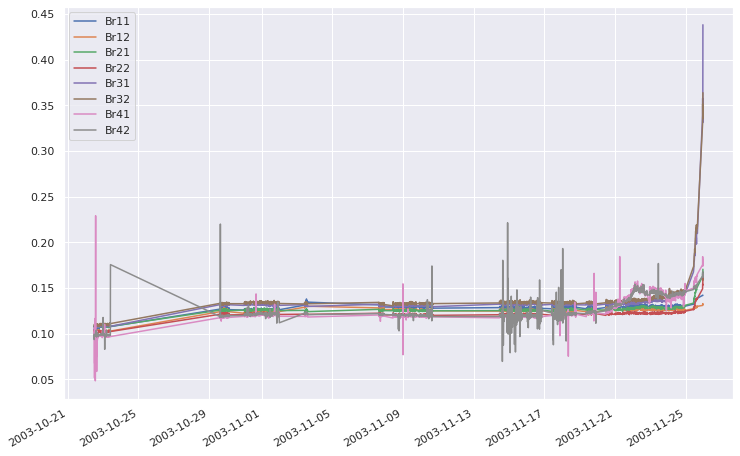

In [7]:
# plot all data
result_data.plot(figsize = FIGSIZE);

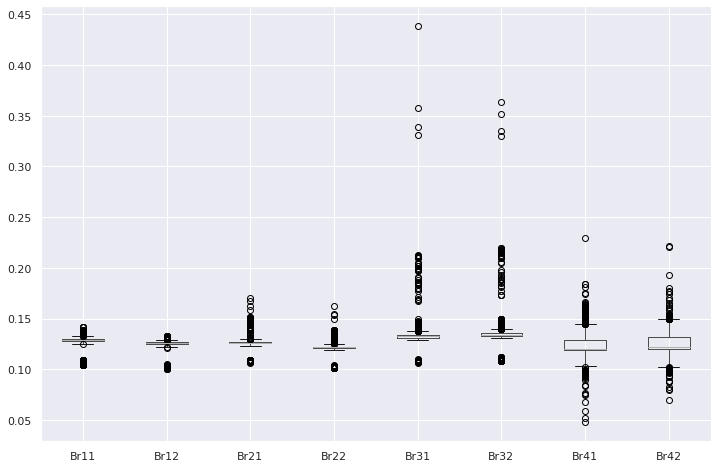

In [8]:
# boxplot
plt.figure(figsize=FIGSIZE)

result_data.boxplot();

# dai boxplot si vede che per almeno due sensori (3,4) ci sono tanti outliers

In [9]:
# Time Series: split train/test on a temporal basis (we don't want o predict the past)

# data from the first interval used for training
START_TIME = '2003-10-25 00:00:01'
SPLIT_TIME = '2003-11-17 23:59:00'

# before the SPLIT_TIME
dataset_train = result_data[START_TIME:SPLIT_TIME]

dataset_test = result_data[SPLIT_TIME:]

In [10]:
# then at a certain point in time vibration start to increase
# and those from some ball bearings "explode"
# dataset_test.plot(figsize = FIGSIZE);

### Data preparation (minMax scaling)

In [11]:
## NN prefer to work with small values... in addition value from different sensors
# have slightly different readings
# better to bring all features on the same scale (0, 1)

# adopt min max scaler
scaler = preprocessing.MinMaxScaler()

# scaler trained only on training set
# scale the data
X_train = pd.DataFrame(scaler.fit_transform(dataset_train), columns = dataset_train.columns, 
                       index = dataset_train.index)

# the same scaler applied to test set (no contamination)
X_test = pd.DataFrame(scaler.transform(dataset_test), columns = dataset_test.columns, 
                      index = dataset_test.index)

#### Define the Autoencoder (NN)

In [12]:
# neurons for layers
# (Encoder) 8 - 6 - 2 - (Decoder) 6 - 8

# number of units per layer
nn_params = {}
nn_params['n1'] = 6
# blottleneck
nn_params['n2'] = 2
nn_params['n3'] = 6
# output must match input
nn_params['n4'] = X_train.shape[1]

def build_model():
    input_num = X_train.shape[1]
    myreg = keras.regularizers.l1(10e-5)
    
    model = Sequential()
    
    # First hidden layer, connected to input vector X. 
    model.add(Dense(nn_params['n1'], activation = "relu",
                # suggested from Chollet Blog on Autoencoders
                activity_regularizer = myreg,
                input_shape=(input_num,)
               )
         )
    
    model.add(Dense(nn_params['n2'], activation = "relu", activity_regularizer = myreg))
    # decoder part
    model.add(Dense(nn_params['n3'], activation = "relu"))
    model.add(Dense(nn_params['n4']))

    model.compile(loss='mse',optimizer='adam')
    
    return model

In [13]:
with strategy.scope():
    model = build_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 54        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 14        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 18        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 56        
Total params: 142
Trainable params: 142
Non-trainable params: 0
_________________________________________________________________


### Train

In [14]:
%%time

# Train the model (120 epochs)
NUM_EPOCHS = 120
BATCH_SIZE = 10
VAL_SPLIT = 0.1
VERBOSE = 0

X = np.array(X_train)

# as we can se, in the fit we assume y = X. Output should match input
history = model.fit(X, X, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS,
                    validation_split = VAL_SPLIT, verbose = VERBOSE)

CPU times: user 38.9 s, sys: 8.6 s, total: 47.5 s
Wall time: 23.3 s


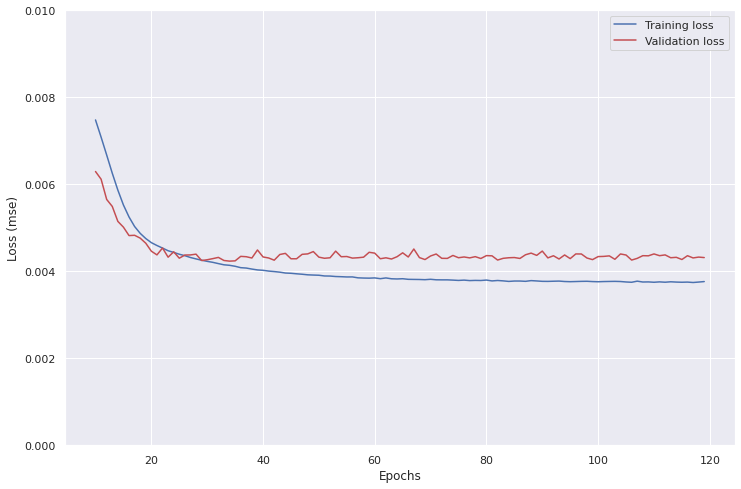

In [15]:
# visualize loss for the training (avoid first epochs to see improvements)

plot_loss(history, start_from=10)

In [16]:
# save the model
model.save('autoencoder1.h5')

/home/datascience/conda/tensorflow23_p37_gpu_v1/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.16)

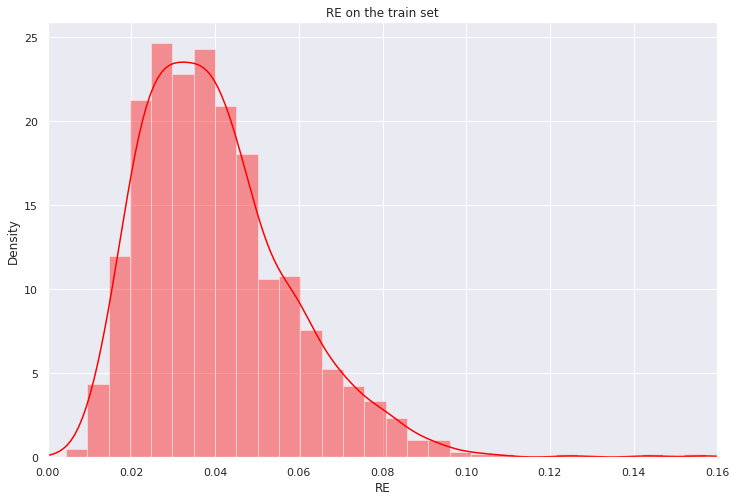

In [17]:
# Decide the threshold (THR)

# prediction on the train dataset 
# RE: reconstruction error, calculated as MAE

# predict
X_pred = model.predict(np.array(X_train))

X_pred = pd.DataFrame(X_pred, columns=X_train.columns, index = X_train.index)

# create a new dataframe for the plot
scored = pd.DataFrame(index = X_train.index)

# for every point compute the reconstruction error as MAE
# the mean of the abs of difference between real value and reconstructed value
scored['RE'] = np.mean(np.abs(X_pred - X_train), axis = 1)

# histogram
plt.figure(figsize = FIGSIZE)
plt.title('RE on the train set')
sns.distplot(scored['RE'], bins = 30, kde= True, color = 'red');
plt.xlim([0.0,.16])

In [18]:
# from plot above, we get the threshold

# ok, THR is an hyper-parameter of the model. It is a design decision. No simple way to define it
# as always THR has an impact on FN and FP. There is a tradeoff
THR = 0.1

In [19]:
# how many points in the train dataset have RE > THR? (so, would be classified as anom?)
print('Train dataset # of points:', scored.shape[0])

scored['Anomaly'] = (scored['RE'] > THR)

num_anom = np.sum(scored['Anomaly'])
perc_anom = round(num_anom*100./scored.shape[0], 2)

print()
print('Train dataset: # of ANOM points:', num_anom)
print('Train dataset: % of ANOM points:', perc_anom, '%')

Train dataset # of points: 1163

Train dataset: # of ANOM points: 6
Train dataset: % of ANOM points: 0.52 %


The THR is an hyper-parameter of the model. As usual, it is a tradeoff between FP and FN
Higher THR can reduce FP but can increase FN (non detected anomalous point). 
It must be a design decision, there is not a magic rule.

### Now simulate real time predictions !!! (on the test set)

In [20]:
# compute prediction on TEST
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, columns = X_test.columns, index = X_test.index)

score = pd.DataFrame(index = X_test.index)
# compute RE as MAE and round
score['RE'] = round(np.mean(np.abs(X_pred - X_test), axis = 1), 3)

# threshold 0.1 (vedi grafico precedente)
score['THR'] = THR # to plot the RED line
score['Anomaly'] = (score['RE'] > THR)

# see predictions on last points (when we know that the fault occurs)
score.tail(5)

,RE,THR,Anomaly
2003-11-25 16:07:32,1.678,0.1,True
2003-11-25 23:13:21,5.167,0.1,True
2003-11-25 23:19:56,5.655,0.1,True
2003-11-25 23:29:56,5.238,0.1,True
2003-11-25 23:39:56,6.579,0.1,True


In [ ]:
# final data all anomalous: OK. We can see that RE is much much higherr than in the train set (5 compared to 0.1)

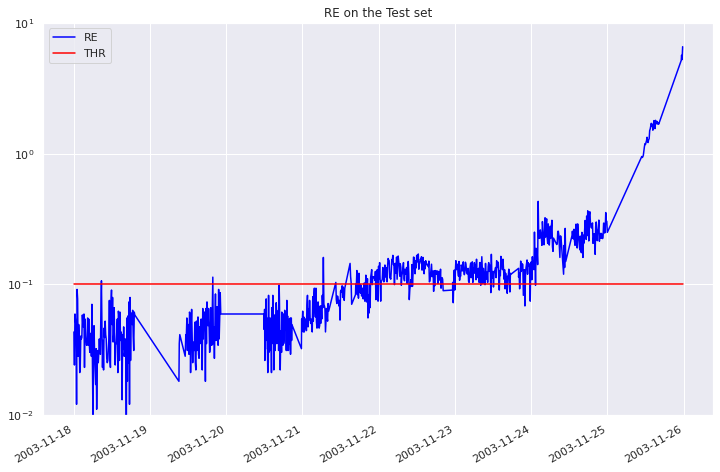

In [21]:
# plot with logaritmic scale y
score.plot(logy=True,  figsize = FIGSIZE, ylim = [1e-2,1e1], color = ['blue','red'], title='RE on the Test set');

In [22]:
# from the plot we see that we could have been able to predict the fault in advance of 4-5 days!!!

### How many alerts per day?

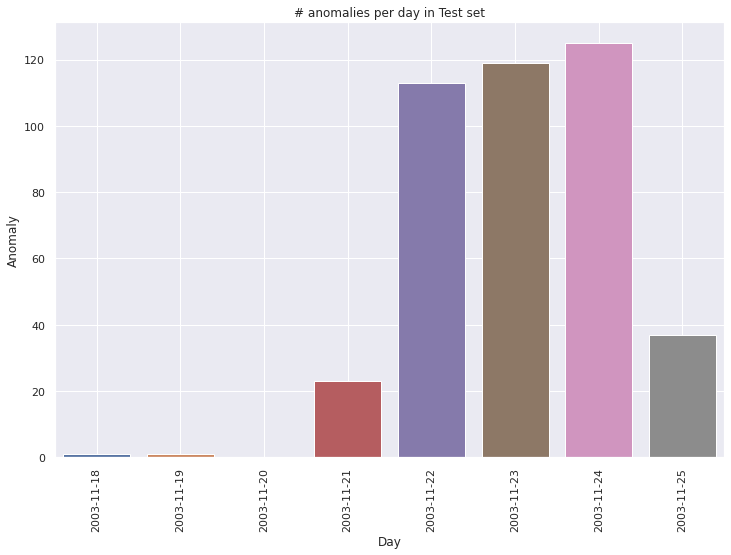

In [24]:
# count how many anomaly alerts (RE > THR) we have per day
# group by by day and sum(Anomaly)

vet_x, vet_y = compute_and_plot_anomalies(score, '# anomalies per day in Test set')

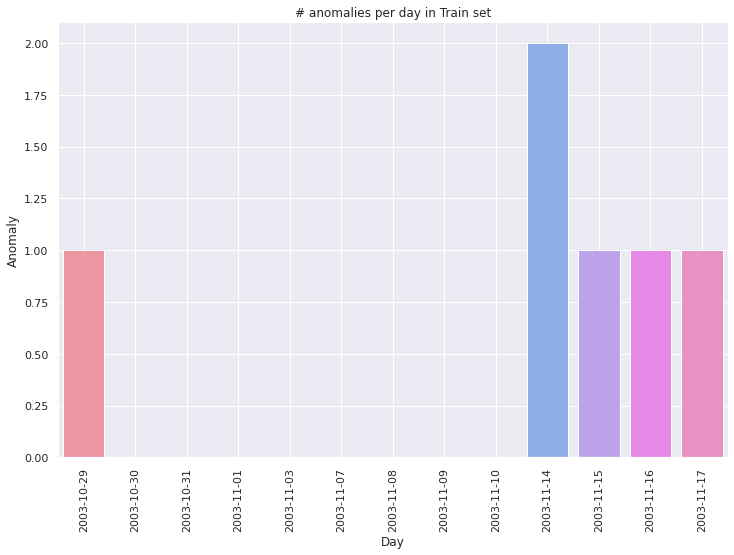

In [26]:
# have a look at training data to see if we have false positive
# i train data vanno fino al 17/11

X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, columns = X_train.columns, index = X_train.index)

score_train = pd.DataFrame(index = X_train.index)
score_train['RE'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
score_train['THR'] = THR
score_train['Anomaly'] = score_train['RE'] > THR

vet_x, vet_y = compute_and_plot_anomalies(score_train, '# anomalies per day in Train set')

Only very rare (1, max 2 per day) anomalies: OK

### Now: have a look at the internal representation produced by the NN

### we build the network with Keras Functional API

In this way we can separate **encoder and decoder** and extract the internal compact reresentation, that we're going to plot (see plot below)

In [27]:
# define the NN

seed(1234)
tf.random.set_seed(1234)

input_num = X_train.shape[1]
myreg = keras.regularizers.l1(10e-5)

input_vec = Input(shape=(input_num,))

# encoder
encoded = Dense(nn_params['n1'], activation='relu', activity_regularizer = myreg)(input_vec)
encoded = Dense(nn_params['n2'], activation='relu', activity_regularizer = myreg)(encoded)

# decoder
decoded = Dense(nn_params['n3'], activation='relu')(encoded)
decoded = Dense(nn_params['n4'])(decoded)

In [28]:
# the complete network
autoencoder = Model(input_vec, decoded)

In [29]:
# only the encoder
encoder = Model(input_vec, encoded)

In [30]:
autoencoder.compile(optimizer='adam', loss='mse')

In [31]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 14        
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 18        
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 56        
Total params: 142
Trainable params: 142
Non-trainable params: 0
_________________________________________________________________


In [32]:
history2 = autoencoder.fit(X, X, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS,
                    validation_split = VAL_SPLIT, verbose = 0)

In [33]:
# obviously training is the same

In [34]:
# sul dataset di test la codifica (in 2 dim.)
# la parte di encoder trasforma il vettore in input (8 val) in una rappresentazione con due coordinate
# quindi la possiamo riportare su un piano x,y

# usiamo solo la parte di enconder
H_pred = encoder.predict(np.array(X_test))

H_pred = pd.DataFrame(H_pred, index = X_test.index)
H_pred['Anomaly'] = score['Anomaly']

In [35]:
H_pred

,0,1,Anomaly
2003-11-18 00:02:30,0.294194,0.481219,False
2003-11-18 00:12:30,0.305773,0.438732,False
2003-11-18 00:22:30,0.285483,0.338365,False
2003-11-18 00:32:30,0.233504,0.260975,False
2003-11-18 00:42:30,0.274822,0.386821,False
...,...,...,...
2003-11-25 16:07:32,1.225701,8.794663,True
2003-11-25 23:13:21,2.363762,20.203060,True
2003-11-25 23:19:56,2.547582,22.197617,True
2003-11-25 23:29:56,2.115978,19.898949,True


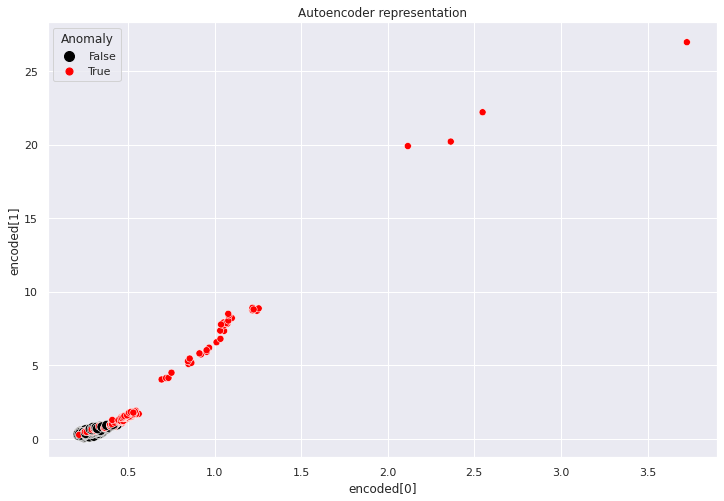

In [36]:
# scatter plot
# H_pred.plot.scatter(x = 0, y = 1, figsize = (12,8))
plt.figure(figsize = FIGSIZE)

plt.xlabel('encoded[0]')
plt.ylabel('encoded[1]')
plt.title('Autoencoder representation')
sns.scatterplot(x= 0, y = 1, hue="Anomaly", size = "Anomaly", sizes = (50, 100), 
                data = H_pred, palette=['black','red'], legend='full');

In [37]:
# have a look at the cluster near the origin (0,0)
condition = ((H_pred[0] < 1) & (H_pred[1] < 4))

select = H_pred[condition]

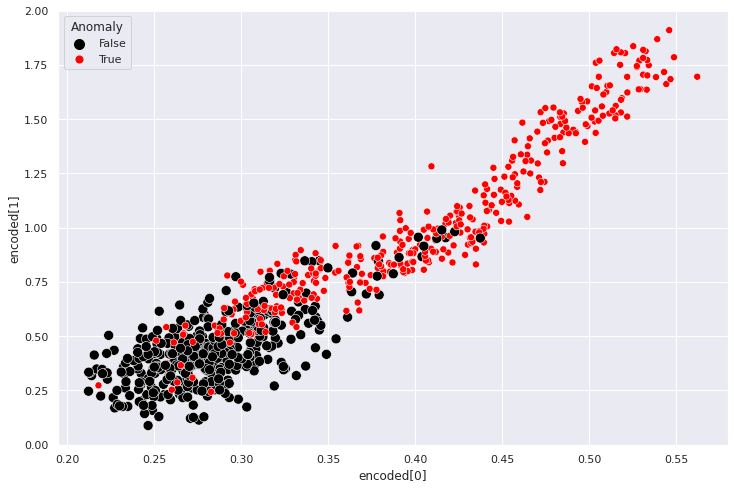

In [38]:
plt.figure(figsize = FIGSIZE)

plt.xlabel('encoded[0]')
plt.ylabel('encoded[1]')

sns.scatterplot(x = 0, y = 1, hue="Anomaly", size = "Anomaly", sizes = (50, 100), 
                data = select, palette=['black','red'], legend='full');